<a href="https://colab.research.google.com/github/lamd91/VAE_DA/blob/master/VAE_MPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import math
import random
from IPython import display
import os
import shutil
from PIL import Image
from google.colab import drive # mount Google Drive at "/content/gdrive"
drive.mount('/content/gdrive') 

seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

Mounted at /content/gdrive


# About this notebook

# Download the Dataset

Upload on Google Drive `mps_simulations.tar.gz` and `strebelle2500.png` located in the "data" directory of the github repository. 
Extract the content of `mps_simulations.tar.gz` here in Colab. The extracted files will be located in a directory named `images`.

In [2]:
!tar -xf "/content/gdrive/My Drive/mps_simulations.tar.gz" 
!rm -r images/.ipynb_checkpoints

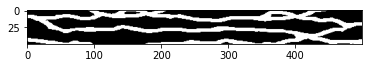

In [3]:
# Show one example of MPS simulation image that will be used for training
i = random.randint(0, 1999)
image = pickle.load(open(f'images/img-{i}.pickle', 'rb')).astype('uint8')
plt.imshow(image, cmap='gray')

Copy the file `strebelle2500.png` in Colab. It will be used to prepare additional image data for training and validation.

In [4]:
!cp -v /content/gdrive/MyDrive/strebelle2500.png .

In [15]:
# Define global constants
BATCH_SIZE = 256
LATENT_DIM = 2
EPOCHS = 1000  # set to a number so as to not exceed RAM
IMAGE_HEIGHT = 50
IMAGE_WIDTH = 500
NUM_CHANNELS = 1
TEST_SIZE = 0.3
SOURCE_DIR = 'images'
TRAINING_DIR = 'training_images'
TESTING_DIR = 'testing_images' 

# Prepare the Dataset

In [6]:
# Make sure `random_indices.pkl` has been uploaded on Google Drive 
def split_data_type1(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    """Split images into training and testing directories"""

    image_filenames = sorted(os.listdir(SOURCE))
    num_examples = len(image_filenames)
    if not os.path.exists(os.path.join(TRAINING, 'input_images')):
        os.makedirs(os.path.join(TRAINING, 'input_images'))
    if not os.path.exists(os.path.join(TESTING, 'input_images')):
        os.makedirs(os.path.join(TESTING, 'input_images'))

    count = 0
    num_training_examples = int(num_examples * (1-SPLIT_SIZE))
    shuffled_indices = pickle.load(
        open('/content/gdrive/My Drive/random_indices.pkl', 'rb'))
    for i in shuffled_indices:
        src = os.path.join(SOURCE, image_filenames[i])
        if os.path.getsize(src) != 0:
            if count < num_training_examples:
                array = pickle.load(open(src, 'rb'))
                img = Image.fromarray(array.astype('uint8')*255, 'L')
                img.save(os.path.join(TRAINING, 
                                      'input_images', 
                                      image_filenames[i].replace('.pickle', '')) + '.png')
            else:
                array = pickle.load(open(src, 'rb'))
                img = Image.fromarray(array.astype('uint8')*255, 'L')
                img.save(os.path.join(TESTING, 
                                      'input_images', 
                                      image_filenames[i].replace('.pickle', '')) + '.png')
            count += 1

    print("Number of training examples:", 
          int(len(os.listdir(os.path.join(TRAINING, 'input_images')))))
    print("Number of validation examples:", 
          int(len(os.listdir(os.path.join(TESTING, 'input_images')))))

split_data_type1(SOURCE_DIR, TRAINING_DIR, TESTING_DIR, 0)

Number of training examples: 2000
Number of validation examples: 0


In [9]:
def extract_subimages_from_image(image_file, num_subimages):
    """Extract random images of fixed size from a given big image"""
    # First resize original image
    img = Image.open(image_file)
    img_resized = img.resize((img.size[0], int(img.size[1]*0.5)))

    # Then extract subimages from the resized image
    subimages = []
    xs_topleft = np.random.randint(0, 2000, num_subimages)
    ys_topleft = np.random.randint(0, 1200, num_subimages)
    for i in range(num_subimages):
        img_crop = img_resized.crop((xs_topleft[i], ys_topleft[i], xs_topleft[i]+IMAGE_WIDTH, ys_topleft[i]+IMAGE_HEIGHT))
        subimages.append(img_crop)

    return subimages

def split_data_type2(image_array, TRAINING, TESTING, SPLIT_SIZE):
    """Split images into training and testing directories"""

    num_examples = len(image_array)
    if not os.path.exists(os.path.join(TRAINING, 'input_images')):
        os.makedirs(os.path.join(TRAINING, 'input_images'))
    if not os.path.exists(os.path.join(TESTING, 'input_images')):
        os.makedirs(os.path.join(TESTING, 'input_images'))

    count = 0
    num_training_examples = int(num_examples * (1-SPLIT_SIZE))
    shuffled_indices = random.sample(range(num_examples), num_examples)
    for i in shuffled_indices:
        if count < num_training_examples:
            image_array[i].save(os.path.join(TRAINING, 'input_images', 'image_') + str(i) + '.png')
        else:
            image_array[i].save(os.path.join(TESTING, 'input_images', 'image_') + str(i) + '.png')
        count += 1

    with open("random_indices.pkl", "wb") as f:
        pickle.dump(shuffled_indices, f)
    print("Number of training examples:", int(len(os.listdir(os.path.join(TRAINING, 'input_images')))))
    print("Number of validation examples:", int(len(os.listdir(os.path.join(TESTING, 'input_images')))))
    print("Shuffled image indices before split:", shuffled_indices)

def prepare_data(TRAINING, TESTING, SPLIT_SIZE, num_examples):
    image_array = extract_subimages_from_image("strebelle2500.png", num_examples)
    with open('subimages.pkl', 'wb') as f:
        pickle.dump(image_array, f)
    split_data_type2(image_array, TRAINING, TESTING, SPLIT_SIZE)

prepare_data(TRAINING_DIR, TESTING_DIR, TEST_SIZE, 10000)
num_examples = int(len(os.listdir(os.path.join(TRAINING_DIR, 'input_images'))))

Number of training examples: 7000
Number of validation examples: 3000
Shuffled image indices before split: [9060, 6150, 7075, 3043, 9598, 6227, 1404, 4839, 4037, 1204, 1344, 4390, 2526, 6225, 2527, 6383, 5188, 5909, 1745, 1499, 85, 5050, 7286, 5896, 4419, 1674, 2170, 1430, 3070, 7061, 7353, 9125, 9088, 8395, 6685, 1692, 430, 1468, 5798, 9080, 1524, 9780, 9798, 5315, 6311, 202, 4781, 6779, 6353, 1387, 9167, 3977, 9370, 8537, 2778, 6237, 2777, 2274, 4405, 4933, 4397, 8079, 2390, 1036, 2739, 7121, 4521, 6899, 4911, 7933, 1260, 5916, 4123, 4040, 8123, 9728, 3203, 7501, 1752, 2219, 4991, 110, 6483, 5443, 6224, 5399, 7212, 5484, 7055, 9738, 2230, 4922, 5253, 9883, 3290, 7848, 5147, 2910, 6524, 5228, 4775, 8044, 9435, 3971, 5339, 6161, 4592, 6437, 5980, 1865, 9238, 3273, 9703, 8939, 2947, 9012, 440, 7563, 3434, 7183, 4773, 1133, 6703, 8180, 2280, 4961, 3965, 4139, 2525, 6932, 6176, 1211, 7357, 9796, 7851, 9539, 6566, 8755, 8300, 6853, 8907, 602, 5890, 8796, 9729, 1392, 1791, 4067, 5816, 2725,

In [10]:
from google.colab import files
files.download('subimages.pkl')
files.download('random_indices.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def split_data_type2(image_array, TRAINING, TESTING, SPLIT_SIZE):
    """Split images into training and testing directories"""

    num_examples = len(image_array)
    if not os.path.exists(os.path.join(TRAINING, 'input_images')):
        os.makedirs(os.path.join(TRAINING, 'input_images'))
    if not os.path.exists(os.path.join(TESTING, 'input_images')):
        os.makedirs(os.path.join(TESTING, 'input_images'))

    count = 0
    num_training_examples = int(num_examples * (1-SPLIT_SIZE))
    shuffled_indices = pickle.load(open('random_indices.pkl', 'rb'))
    for i in shuffled_indices:
        if count < num_training_examples:
            image_array[i].save(os.path.join(TRAINING, 'input_images', 'image_') + str(i) + '.png')
        else:
            image_array[i].save(os.path.join(TESTING, 'input_images', 'image_') + str(i) + '.png')
        count += 1

    with open("random_indices.pkl", "wb") as f:
        pickle.dump(shuffled_indices, f)
    print("Number of training examples:", int(len(os.listdir(os.path.join(TRAINING, 'input_images')))))
    print("Number of validation examples:", int(len(os.listdir(os.path.join(TESTING, 'input_images')))))
    print("Shuffled image indices before split:", shuffled_indices)

def prepare_data(TRAINING, TESTING, SPLIT_SIZE, num_examples):
    image_array = pickle.load(open('subimages.pkl', 'rb'))
    split_data_type2(image_array, TRAINING, TESTING, SPLIT_SIZE)

prepare_data(TRAINING_DIR, TESTING_DIR, TEST_SIZE, 2000)
num_examples = int(len(os.listdir(os.path.join(TRAINING_DIR, 'input_images'))))

In [16]:
def create_data_generators():
    """Create generators of training data and validation data""" 
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale = 1.0/255.0,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode='nearest'    
    )

    val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale = 1.0/255.0
    )

    train_generator = train_datagen.flow_from_directory(
        directory = TRAINING_DIR,
        batch_size = BATCH_SIZE,
        target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
        color_mode = 'grayscale', # images will be converted to have 1 channel
        class_mode = 'input', # labels will be images identical to input images
    )

    val_generator = val_datagen.flow_from_directory(
        directory = TESTING_DIR,
        batch_size = BATCH_SIZE,
        target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
        color_mode = 'grayscale',
        class_mode = 'input'
    )

    return train_generator, val_generator

train_generator, val_generator = create_data_generators()

Found 7000 images belonging to 1 classes.
Found 3000 images belonging to 1 classes.


# Build the model

In [17]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        """Generates a random sample and combines with the encoder output

        Args:
          inputs -- output tensor from the encoder

        Returns:
          `inputs` tensors combined with a random sample
        """

        # unpack the output of the encoder
        mu, sigma = inputs

        # get the size and dimensions of the batch
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]

        # generate a random tensor
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

        # combine the inputs and noise
        return mu + tf.exp(0.5 * sigma) * epsilon


def encoder_layers(inputs, latent_dim):
    """Defines the encoder's layers.
    Args:
      inputs -- batch from the dataset
      latent_dim -- dimensionality of the latent space

    Returns:
      mu -- learned mean
      sigma -- learned standard deviation
      batch_2.shape -- shape of the features before flattening
    """

    # add the Conv2D layers followed by BatchNormalization
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, 
                               padding="same", activation='relu',
                               name="encode_conv1")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, 
                               padding='same', activation='relu',
                               name="encode_conv2")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, 
                               padding='same', activation='relu',
                               name="encode_conv3")(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=2, 
    #                            padding='same', activation='relu',
    #                            name="encode_conv4")(x)   
                               
    # assign to a different variable so you can extract the shape later
    batch_3 = tf.keras.layers.BatchNormalization()(x)

    # flatten the features and feed into the Dense network
    x = tf.keras.layers.Flatten(name="encode_flatten")(batch_3)

    # we arbitrarily used ... units here but feel free to change
    x = tf.keras.layers.Dense(1024, activation='relu', name="encode_dense")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # add output Dense networks for mu and sigma, units equal to the declared latent_dim.
    mu = tf.keras.layers.Dense(latent_dim, name='latent_mu')(x)
    sigma = tf.keras.layers.Dense(latent_dim, name='latent_sigma')(x)

    return mu, sigma, batch_3.shape

def encoder_model(latent_dim, input_shape):
    """Defines the encoder model with the Sampling layer
    Args:
      latent_dim -- dimensionality of the latent space
      input_shape -- shape of the dataset batch

    Returns:
      model -- the encoder model
      conv_shape -- shape of the features before flattening
    """

    # declare the inputs tensor with the given shape
    inputs = tf.keras.layers.Input(shape=input_shape)

    # get the output of the encoder_layers() function
    mu, sigma, conv_shape = encoder_layers(inputs, latent_dim=LATENT_DIM)

    # feed mu and sigma to the Sampling layer
    z = Sampling()((mu, sigma))

    # build the whole encoder model
    model = tf.keras.Model(inputs, outputs=[mu, sigma, z])

    return model, conv_shape


# Define decision variables for adding Cropping2D layers in decoder layers

topcrop_after_upsampling0 = (math.ceil(math.ceil(math.ceil(IMAGE_HEIGHT/2)/2)/2) % 2 != 0)
leftcrop_after_upsampling0 = (math.ceil(math.ceil(math.ceil(IMAGE_WIDTH/2)/2)/2) % 2 != 0)
topcrop_after_upsampling1 = (math.ceil(math.ceil(IMAGE_HEIGHT/2)/2) % 2 != 0)
leftcrop_after_upsampling1 = (math.ceil(math.ceil(IMAGE_WIDTH/2)/2) % 2 != 0)
topcrop_after_upsampling2 = (math.ceil(IMAGE_HEIGHT/2) % 2 != 0)
leftcrop_after_upsampling2 = (math.ceil(IMAGE_WIDTH/2) % 2 != 0)
topcrop_after_upsampling3 = (IMAGE_HEIGHT % 2 != 0)
leftcrop_after_upsampling3 = (IMAGE_WIDTH % 2 != 0)


def decoder_layers(inputs, conv_shape, topcrop_after_upsampling1, 
                   leftcrop_after_upsampling1, topcrop_after_upsampling2, 
                   leftcrop_after_upsampling2,
                   topcrop_after_upsampling3, leftcrop_after_upsampling3):
    """Defines the decoder layers.
    Args:
      inputs -- output of the encoder
      conv_shape -- shape of the features before flattening

    Returns:
      tensor containing the decoded output
    """

    # feed to a Dense network with units computed from the conv_shape dimensions
    units = conv_shape[1] * conv_shape[2] * conv_shape[3]
    x = tf.keras.layers.Dense(units, activation='relu', name="decode_dense1")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)

    # reshape output using the conv_shape dimensions
    x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]), 
                                name="decode_reshape")(x)

    # upsample the features back to the original dimensions
    # for that, make sure to add Cropping2D layers after upsampling when needed
    # x = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, 
    #                                     padding='same', activation='relu',
    #                                     name="decode_conv2d_0")(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # if topcrop_after_upsampling0:
    #     x = tf.keras.layers.Cropping2D(cropping=((1, 0), (0, 0)))(x)
    # if leftcrop_after_upsampling0:
    #     x = tf.keras.layers.Cropping2D(cropping=((0, 0), (1, 0)))(x) 
    x = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, 
                                        padding='same', activation='relu',
                                        name="decode_conv2d_1")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if topcrop_after_upsampling1:
        x = tf.keras.layers.Cropping2D(cropping=((1, 0), (0, 0)))(x)
    if leftcrop_after_upsampling1:
        x = tf.keras.layers.Cropping2D(cropping=((0, 0), (1, 0)))(x)
    x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, 
                                        padding='same', activation='relu',
                                        name="decode_conv2d_2")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if topcrop_after_upsampling2:
        x = tf.keras.layers.Cropping2D(cropping=((1, 0), (0, 0)))(x)
    if leftcrop_after_upsampling2:
        x = tf.keras.layers.Cropping2D(cropping=((0, 0), (1, 0)))(x)
    x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, 
                                        padding='same', activation='relu',
                                        name="decode_conv2d_3")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    if topcrop_after_upsampling3:
        x = tf.keras.layers.Cropping2D(cropping=((1, 0), (0, 0)))(x)
    if leftcrop_after_upsampling3:
        x = tf.keras.layers.Cropping2D(cropping=((0, 0), (1, 0)))(x)
    x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                        padding='same', activation='sigmoid',
                                        name="decode_final")(x)

    return x

def decoder_model(latent_dim, conv_shape):
    """Defines the decoder model.
    Args:
      latent_dim -- dimensionality of the latent space
      conv_shape -- shape of the features before flattening

    Returns:
      model -- the decoder model
    """

    # set the inputs to the shape of the latent space
    inputs = tf.keras.layers.Input(shape=(latent_dim,))

    # get the output of the decoder layers
    outputs = decoder_layers(inputs, conv_shape, topcrop_after_upsampling1, 
                             leftcrop_after_upsampling1, 
                             topcrop_after_upsampling2, 
                             leftcrop_after_upsampling2, 
                             topcrop_after_upsampling3, 
                             leftcrop_after_upsampling3)

    # declare the inputs and outputs of the model
    model = tf.keras.Model(inputs, outputs)

    return model

def kl_reconstruction_loss(inputs, outputs, mu, sigma):
    """ Computes the Kullback-Leibler Divergence (KLD) used to improve the
    generative capability of the model

    Args:
      inputs -- batch from the dataset
      outputs -- output of the Sampling layer
      mu -- mean
      sigma -- standard deviation

    Returns:
      KLD loss
    """
    kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
    kl_loss = tf.reduce_mean(kl_loss) * -0.5

    return kl_loss

def vae_model(encoder, decoder, input_shape):
    """Defines the VAE model
    Args:
      encoder -- the encoder model
      decoder -- the decoder model
      input_shape -- shape of the dataset batch

    Returns:
      the complete VAE model
    """
    # set the inputs
    inputs = tf.keras.layers.Input(shape=input_shape)

    # get mu, sigma, and z from the encoder output
    mu, sigma, z = encoder(inputs)

    # get reconstructed output from the decoder
    reconstructed = decoder(z)

    # define the inputs and outputs of the VAE
    model = tf.keras.Model(inputs=inputs, outputs=reconstructed)

    # add the KL loss
    loss = kl_reconstruction_loss(inputs, z, mu, sigma)
    model.add_loss(loss)

    return model

def get_models(input_shape, latent_dim):
    """Returns the encoder, decoder, and vae models"""
    encoder, conv_shape = encoder_model(latent_dim=latent_dim, input_shape=input_shape)
    decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)
    vae = vae_model(encoder, decoder, input_shape=input_shape)
    return encoder, decoder, vae

In [18]:
# Define a VAE class via model subclassing
loss_metrics = tf.keras.metrics.Mean()
val_loss_metrics = tf.keras.metrics.Mean()

class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, variational_autoencoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.vae = variational_autoencoder

    # override train_step method
    def train_step(self, images):
        if isinstance(images, tuple):
            images = images[0]
        with tf.GradientTape() as tape:
            # feed a batch to the VAE model
            reconstructed = self.vae(images)
            # compute reconstruction loss
            flattened_inputs = tf.reshape(images, [-1])
            flattened_outputs = tf.reshape(reconstructed, [-1])
            loss = self.compiled_loss(flattened_inputs, flattened_outputs) \
                   * images.shape[1] * images.shape[2]
            # add KLD regularization loss
            loss += sum(self.vae.losses)

        # compute the gradients and update the model weights
        grads = tape.gradient(loss, self.vae.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.vae.trainable_weights))

        # update metrics
        loss_metrics.update_state(loss)
        
        # return a dict mapping metrics names to current value
        return {'loss': loss_metrics.result()}

    # override test_step method
    def test_step(self, images):
        if isinstance(images, tuple):
            images = images[0]
        # compute predictions
        reconstructed = self.vae(images)
        # compute loss
        flattened_inputs = tf.reshape(images, [-1])
        flattened_outputs = tf.reshape(reconstructed, [-1])
        loss = self.compiled_loss(flattened_inputs, flattened_outputs) \
               * images.shape[1] * images.shape[2]
        # add KLD regularization loss
        loss += sum(self.vae.losses)
        # update metrics
        val_loss_metrics.update_state(loss)
        # return a dict mapping metrics names to current value
        return {'loss': val_loss_metrics.result()}

    def call(self, images):
        if isinstance(images, tuple):
            images = images[0]
        return self.vae(images)

# Display utilities

In [19]:
def generate_and_save_images(model, epoch, step, test_input, vae_model):
    """Helper function to plot our 8 images

    Args:

    model -- the decoder model
    epoch -- current epoch number during training
    step -- current step number during training
    test_input -- random tensor with shape (8, LATENT_DIM)
    """

    # generate images from the test input
    predictions = model.predict(test_input)

    # plot the results
    fig = plt.figure(figsize=(12, 14))

    for i in range(predictions.shape[0]):
        plt.subplot(8, 1, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    fig.suptitle("epoch: {}, step: {}".format(epoch, step))
    plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))

    if epoch != 0:
        fig = plt.figure()
        plt.scatter(range(len(vae_model.history.history['loss'])), 
                    vae_model.history.history['loss'])
        plt.scatter(range(len(vae_model.history.history['val_loss'])), 
                    vae_model.history.history['val_loss'], color='red')
        plt.savefig('Losses.png')
    plt.show()

def show_original_reconstructed_images(model, generator):
    plt.figure(figsize=(10, 14))
    input_images, _ = generator.next()
    k = 0
    for i in range(5):
        reconstructed = model(np.expand_dims(input_images[i], axis=0))
        #reconstructed_categorized = np.where(reconstructed >= 0.5, 1, 0)
        plt.subplot(5, 2, k+1)
        plt.imshow(np.squeeze(input_images[i]), cmap='gray')
        plt.subplot(5, 2, k+2)
        #plt.imshow(np.squeeze(reconstructed_categorized), cmap='gray')
        plt.imshow(np.squeeze(reconstructed), cmap='gray')
        k += 2
        plt.savefig("reconstructed_images.png")
    plt.show()

# Choose the learning rate parameter
Set a learning rate scheduler for selecting a suitable learning rate value for training.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed_value)

# Create a callback that saves the model's weights every few epochs during training
checkpoint_path = 'checkpoint/cp-cp{epoch:04d}.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    verbose = 1,
    save_weights_only = True,
    save_freq = math.ceil(num_examples/BATCH_SIZE) * 100
)

# Create custom callback to display outputs (via helper function) at the end of each epoch of training
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        # Generate random vector as test input to the decoder
        random_vector_for_generation = tf.random.normal(shape=[8, LATENT_DIM])
        # Generate and save images
        display.clear_output(wait=False)
        if epoch % 100 == 0:
            generate_and_save_images(decoder, epoch, 
                                     math.ceil(num_examples/BATCH_SIZE), 
                                     random_vector_for_generation, vae)
        print('End of epoch {} - mean loss = {}'.format(epoch, logs[keys[0]]))

# Create callback for adjusting learning rate during training
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))

# Get the encoder, decoder and 'master' model (called vae)
encoder, decoder, var_autoencoder = get_models(
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS,), 
    latent_dim=LATENT_DIM)

# Instantiate VAE class
vae = VAE(encoder, decoder, var_autoencoder)

# Compile model
vae.compile(
    optimizer = tf.keras.optimizers.Adam(lr=1e-6),
    loss = tf.keras.losses.BinaryCrossentropy()
)

# Generate random vector as test input to the decoder
random_vector_for_generation = tf.random.normal(shape=[8, LATENT_DIM])

# Initialize the helper function to display outputs from an untrained model
generate_and_save_images(decoder, 0, 0, random_vector_for_generation, vae)

# Training loop using original dataset
history = vae.fit(train_generator, epochs=100, verbose=1, 
                  callbacks=[cp_callback, CustomCallback(), lr_schedule])

End of epoch 99 - mean loss = nan


(1e-06, 0.01, 14000.0, 17500.0)

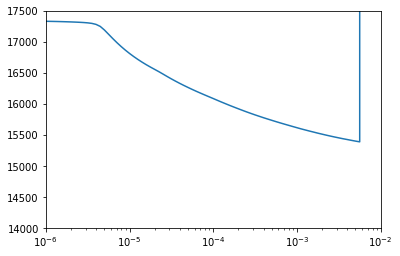

In [ ]:
# Plot losses against learning rates
plt.semilogx(vae.history.history['lr'], vae.history.history['loss'])
plt.axis([1e-6, 0.01, 14000, 17500])

To train the model, we will set the learning rate parameter to `8e-4`. We noted that a larger value would lead to model divergence (infinite loss values).



# Train the VAE model
Train the model using a proper learning rate value. 

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed_value)

# Create a callback that saves the model's weights every few epochs during training
checkpoint_path = './cp-cp{epoch:04d}.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    verbose = 1,
    save_weights_only = True,
    save_freq = math.ceil(num_examples/BATCH_SIZE) * 100
)

# Create custom callback to display outputs (via helper function) at the end of each epoch of training
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        # Generate random vector as test input to the decoder
        random_vector_for_generation = tf.random.normal(shape=[8, LATENT_DIM])
        # Generate and save images
        print('End of epoch {} - mean loss = {}'.format(epoch, logs[keys[0]]))
        display.clear_output(wait=False)
        if epoch % 100 == 0:
            generate_and_save_images(decoder, epoch, 
                                     math.ceil(num_examples/BATCH_SIZE), 
                                     random_vector_for_generation, vae)

# Get the encoder, decoder and 'master' model (called vae)
encoder, decoder, var_autoencoder = get_models(
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS,), 
    latent_dim=LATENT_DIM)
encoder.summary()
decoder.summary()

# Instantiate VAE class
vae = VAE(encoder, decoder, var_autoencoder)

# Compile model
vae.compile(
    optimizer = tf.keras.optimizers.Adam(lr=8e-4),
    loss = tf.keras.losses.BinaryCrossentropy()
)

# Generate random vector as test input to the decoder
random_vector_for_generation = tf.random.normal(shape=[8, LATENT_DIM])

# Initialize the helper function to display outputs from an untrained model
generate_and_save_images(decoder, 0, 0, random_vector_for_generation, vae)

# Training loop using original dataset
history = vae.fit(x=train_generator, 
                  epochs=EPOCHS,  
                  verbose=1, 
                  validation_data = val_generator, 
                  callbacks=[cp_callback, CustomCallback()])      

Epoch 144/1000
 4/28 [===>..........................] - ETA: 14s - loss: 13600.3979

In [ ]:
# Plot evolution of train and validation losses during training
plt.scatter(range(len(vae.history.history['loss'])), 
            vae.history.history['loss'], 
            label='training loss')
plt.scatter(range(len(vae.history.history['val_loss'])), 
            vae.history.history['val_loss'], 
            color='red',
            label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

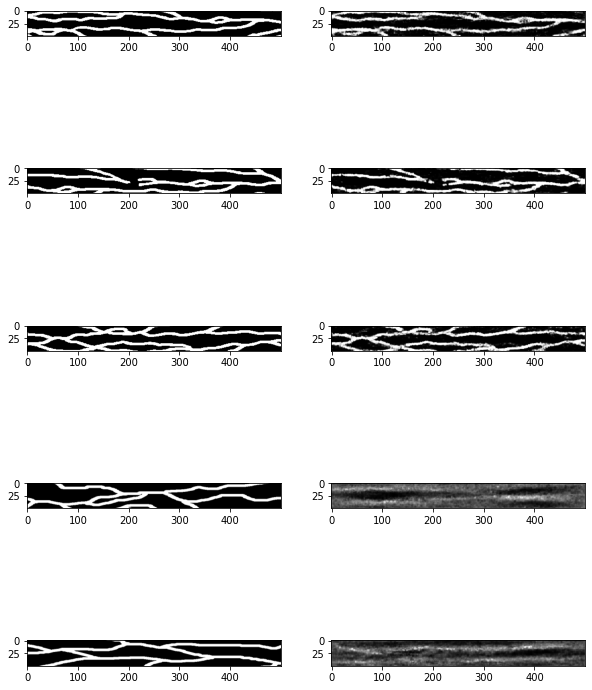

In [ ]:
# Show image from training set on the left VS the image reconstructed by the 
# trained model on the right
show_original_reconstructed_images(vae, train_generator)

# Resume the training if necessary

Files containing the last model weights saved during training are located in the `checkpoint` folder of the github repository. 

After reinitializing the Colab environment, run the cell below to instantiate a new VAE model, load the weights from the checkpoint files that you will have uploaded beforehand in your Google Drive and resume the training if necessary. 

### Set a learning rate scheduler to select an appropriate learning rate parameter 

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed_value)

# Create callback for adjusting learning rate during training
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))

# Get the encoder, decoder and 'master' model (called vae)
encoder, decoder, var_autoencoder = get_models(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS,), latent_dim=LATENT_DIM)

# Create new instance of VAE class
new_vae = VAE(encoder, decoder, var_autoencoder)

# Load weights from last checkpoint
checkpoint_dir = '/content/gdrive/My Drive/'
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)

# Compile model
new_vae.compile(
    optimizer = tf.keras.optimizers.Adam(lr=1e-6),
    loss = tf.keras.losses.BinaryCrossentropy()
)

# Training loop using original dataset
history = new_vae.fit(train_generator, epochs=100, verbose=1, 
                  callbacks=[lr_schedule])

In [ ]:
# Plot losses against learning rates
plt.semilogx(new_vae.history.history['lr'], new_vae.history.history['loss'])
plt.axis([1e-6, 0.01, 14000, 17500])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(seed_value)

# Get the encoder, decoder and 'master' model (called vae)
encoder, decoder, var_autoencoder = get_models(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS,), latent_dim=LATENT_DIM)

# Create new instance of VAE class
new_vae = VAE(encoder, decoder, var_autoencoder)

# Load weights from last checkpoint
checkpoint_dir = '/content/gdrive/My Drive/'
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)

/content/gdrive/My Drive/cp-cp0488.ckpt


In [ ]:
new_vae.load_weights(latest)
new_vae.compile(
    optimizer = tf.keras.optimizers.Adam(8e-4), # decrease lr if unstable loss decrease
    loss = tf.keras.losses.BinaryCrossentropy()
)

In [ ]:
new_vae.evaluate(train_generator, verbose=1)

33/33 [==============================] - 3s 68ms/step - loss: 14828.0400


14812.3642578125

In [ ]:
# Create a callback that saves the model's weights every few epochs during training
checkpoint_path = './cp-cp{epoch:04d}.ckpt'
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    verbose = 1,
    save_weights_only = True,
    save_freq = math.ceil(num_examples*(1-TEST_SIZE)/BATCH_SIZE) * 100
)
# Create custom callback to display outputs at the end of each epoch of training
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        # Generate random vector as test input to the decoder
        random_vector_for_generation = tf.random.normal(shape=[8, LATENT_DIM])
        # Generate and save images
        display.clear_output(wait=True)
        if epoch % 100 == 0:
            generate_and_save_images(decoder, epoch, 
                                     math.ceil(num_examples/BATCH_SIZE), 
                                     random_vector_for_generation, new_vae)
        print('End of epoch {} - mean loss = {}'.format(epoch, logs[keys[0]]))

# Resume training using original dataset
new_vae.fit(x=train_generator, epochs=1000, 
            verbose=1, 
            validation_data=val_generator, 
            callbacks=[cp_callback, CustomCallback()])

End of epoch 393 - mean loss = 11538.9326171875
Epoch 395/1000
28/33 [========================>.....] - ETA: 0s - loss: 11538.0439

KeyboardInterrupt: ignored

In [ ]:
# Plot evolution of train and validation losses during training
plt.scatter(range(len(new_vae.history.history['loss'])), 
            new_vae.history.history['loss'], 
            label = 'training loss')
plt.scatter(range(len(new_vae.history.history['val_loss'])), 
            new_vae.history.history['val_loss'], color='red', 
            label ='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot Reconstructed Images
Compare some images from the validation set with the images predicted from the trained model

In [ ]:
# Show image from training set on the left VS the image reconstructed by the 
# trained model on the right
show_original_reconstructed_images(new_vae, train_generator)

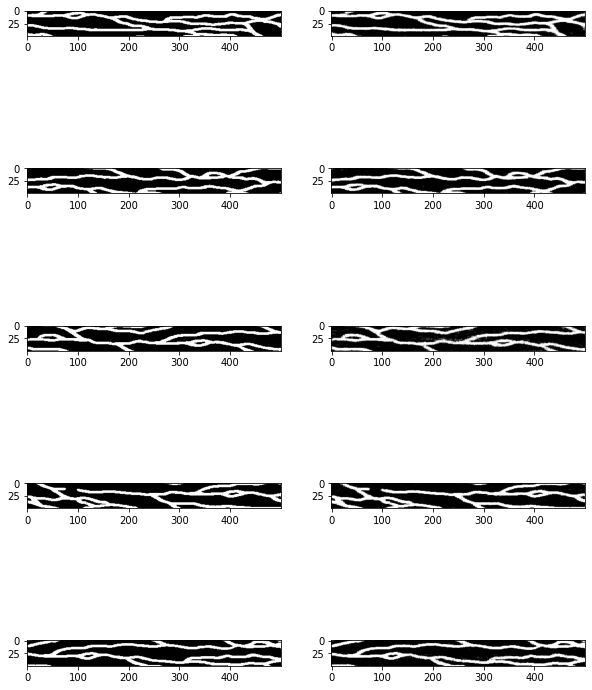

In [ ]:
# Show image from validation set on the left VS the image reconstructed by the 
# trained model on the right
show_original_reconstructed_images(new_vae, val_generator)

# Generate new images

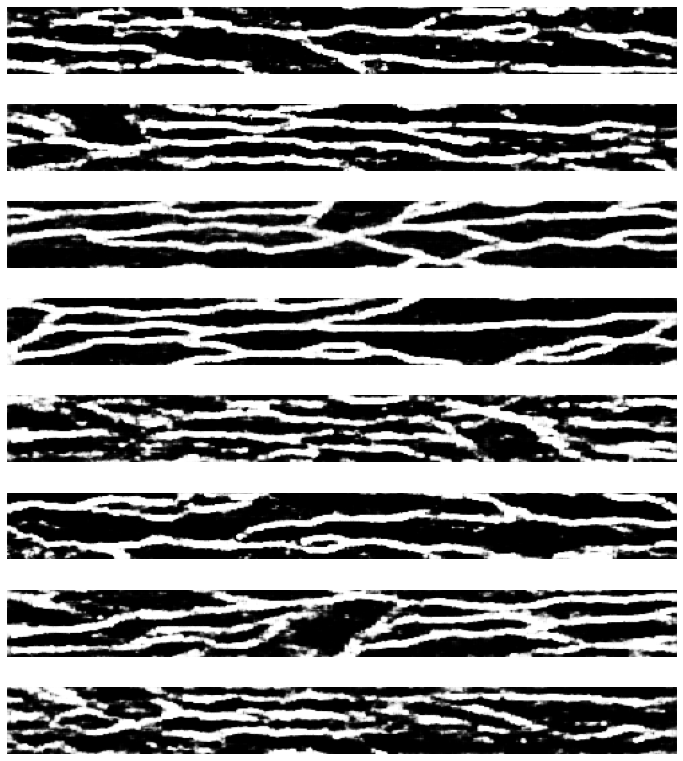

In [ ]:
# Generate random vector as test input to the decoder
test_input = tf.random.normal(shape=[8, LATENT_DIM])

# Generate images from the test input
predictions = new_vae.decoder.predict(test_input)

# plot the results
fig = plt.figure(figsize=(12, 14))

for i in range(predictions.shape[0]):
    plt.subplot(8, 1, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

# Performance on images from validation set

In [ ]:
show_original_reconstructed_images(new_vae, val_generator)

In [ ]:
while True:
    pass